In [80]:
!hostname

n100.clstr


In [89]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xesmf as xe

In [82]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)


Loading in 4km ERA5

In [83]:
#/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files

path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/'
compare=f'ROS_Monthly*.nc'
file_list = sorted(glob.glob(os.path.join(path, compare)))
combined_ds=xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
oceanmask=geo['LU_INDEX']
oceanmask=oceanmask.squeeze(dim='Time')
#oceanmask_expanded = oceanmask.expand_dims(Time=data.Time)

ERA5_4km = combined_ds.where(oceanmask != 17)

lat_era5_4km=ERA5_4km['XLAT']
lon_era5_4km=ERA5_4km['XLONG']
monthlist=['November','December','January','February','March' ]
monthnumberlist=[11,12,1,2,3]

In [84]:
path='/center1/DYNDOWN/phutton5/ROS/Raw_ERA5/Raw_ERA5_netcdf'
pattern=f'Raw_ERA5_ROS_Monthly*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
ERA5_raw = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')
#data = data.fillna(0)

seasons=ERA5_raw['season']
lat_raw=ERA5_raw['latitude']
lon_raw=ERA5_raw['longitude']

ERA5_31km=ERA5_raw
#raw era5 lat dim 68 and long 190 
#era5 4km lat 450 and  long 420 

<xarray.Dataset> Size: 6GB
Dimensions:              (season: 73, month: 5, south_north: 450,
                          west_east: 420, interp_level: 3)
Coordinates:
  * season               (season) <U9 3kB '1950-1951' ... '2022-2023'
  * month                (month) int64 40B 11 12 1 2 3
    XLAT                 (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
    XLONG                (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
  * interp_level         (interp_level) float64 24B 850.0 925.0 950.0
    month_name           (month) <U3 60B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables: (12/13)
    ros_tally            (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ros_counts           (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ros_days_count       (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_sum             (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_ros_sum         (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_avg             (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ...                   ...
    swe_avg              (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    swe_ros_avg          (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    T2_avg               (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    T2_ros_avg           (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    temp_levels_avg      (season, month, interp_level, south_north, west_east) float32 828MB dask.array<chunksize=(1, 3, 2, 450, 420), meta=np.ndarray>
    temp_levels_ros_avg  (season, month, interp_level, south_north, west_east) float32 828MB dask.array<chunksize=(1, 3, 2, 450, 420), meta=np.ndarray>

REGRIDDING AND SAVING the data 
-

In [85]:
import xarray as xr
import xesmf as xe

lat_coarse = ERA5_31km["latitude"]
lon_coarse = ERA5_31km["longitude"]
src_grid = xr.Dataset({"lat": lat_coarse, "lon": lon_coarse})

lat_fine = ERA5_4km["XLAT"]
lon_fine = ERA5_4km["XLONG"]

tgt_grid = xr.Dataset({"lat": lat_fine, "lon": lon_fine})

regridder = xe.Regridder(src_grid, tgt_grid, method="bilinear", periodic=False, reuse_weights=False)

vars_to_regrid = [
    v for v in ERA5_31km.data_vars
    if {"latitude", "longitude"}.issubset(ERA5_31km[v].dims)
]

ERA5_31_to_4km = xr.Dataset()
for v in vars_to_regrid:
    ERA5_31_to_4km[v] = regridder(ERA5_31km[v])

#ONLY SAVE IF NEEDED IT WORKED!
#ERA5_31_to_4km.to_netcdf("/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/trial_nearest_regridded_ERA5_31kmto4km_ROS.nc")
print("Saved regridded 31km → 4km data to NetCDF!")

Saved regridded 31km → 4km data to NetCDF!


In [87]:
ERA5_31_to_4km

<xarray.Dataset> Size: 10GB
Dimensions:              (season: 73, month: 5, south_north: 450, west_east: 420)
Coordinates:
  * season               (season) <U9 3kB '1950-1951' ... '2022-2023'
  * month                (month) int64 40B 11 12 1 2 3
    month_name           (month) <U3 60B dask.array<chunksize=(5,), meta=np.ndarray>
    XLAT                 (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
    XLONG                (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables: (12/19)
    ros_tally            (season, month, south_north, west_east) int64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ros_counts           (season, month, south_north, west_east) int64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ros_days_count       (season, month, south_north, west_east) int64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_sum             (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_ros_sum         (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_avg             (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ...                   ...
    T2_avg               (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    T2_ros_avg           (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    sumtotal_precip      (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    sumtotal_precip_ros  (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    avgtotal_precip      (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    avgtotal_precip_ros  (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>

In [ ]:
ERA5_4km_regridded.transpose("latitude", "longitude",...)

In [9]:
#This regrids 4km to 31km 
'''import xarray as xr
import xesmf as xe

src_grid = xr.Dataset({"lat": ERA5_4km["XLAT"], "lon": ERA5_4km["XLONG"],})

lon2d, lat2d = xr.broadcast(lon_raw, lat_raw)

tgt_grid = xr.Dataset({"lat": lat2d,"lon": lon2d,})

regridder = xe.Regridder(src_grid, tgt_grid, method="nearest_s2d", periodic=False, reuse_weights=False) #method="bilinear"

vars_to_regrid = [
    v for v in ERA5_4km.data_vars
    if {"south_north", "west_east"}.issubset(ERA5_4km[v].dims)]

ERA5_4km_regridded = xr.Dataset()
for v in vars_to_regrid:
    ERA5_4km_regridded[v] = regridder(ERA5_4km[v])

ERA5_4km_regridded.transpose("latitude", "longitude",...)


ERA5_4km_regridded.to_netcdf("/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/nearest_regridded_ERA5_4km_ROS.nc")
print("Saved ROS stats to NetCDF!")'''

/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/xesmf/backend.py:42: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


Saved ROS stats to NetCDF!


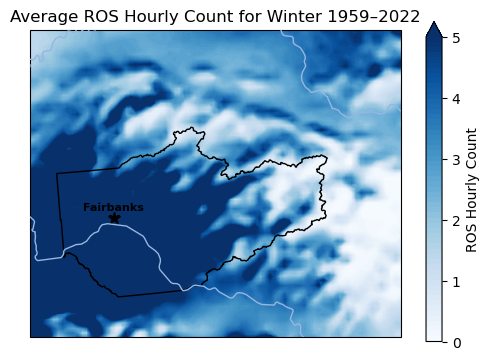

In [60]:
lat=ERA5_4km['XLAT']
lon=ERA5_4km['XLONG']
season_sums = ERA5_4km['ros_tally'].sum(dim='month')
season_avg=np.mean(season_sums,axis=0)

AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(0, 5,60)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, season_avg, levels=levels,extend='max',cmap='Blues',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(np.arange(0,6,1))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Average ROS Hourly Count for Winter 1959–2022")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

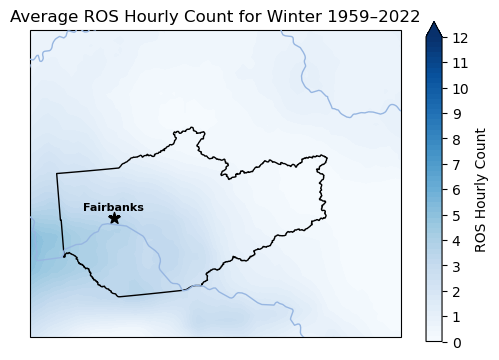

In [73]:
ERA5_31_to_4km
lat=ERA5_31_to_4km['XLAT']
lon=ERA5_31_to_4km['XLONG']
season_sums = ERA5_31_to_4km['ros_tally'].sum(dim='month')
season_avg=np.mean(season_sums,axis=0)

AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.linspace(0, 12,60)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, season_avg, levels=levels,extend='max',cmap='Blues',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(np.arange(0,13,1))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Average ROS Hourly Count for Winter 1959–2022")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

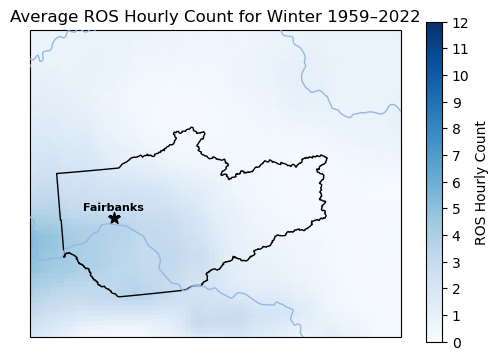

In [78]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    figsize=(10, 4)
    )
season_sums = ERA5_31_to_4km['ros_tally'].sum(dim='month')
season_avg=np.mean(season_sums,axis=0)
pm = ax.pcolormesh(
    lon,
    lat,
    season_avg,
    cmap='Blues',
    vmin=0,
    vmax=12,
    shading='auto',   # IMPORTANT
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(pm, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(np.arange(0, 13, 1))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=1,
    zorder=2,
    transform=ccrs.PlateCarree()
)

ax.scatter(
    Fairbanks_lon,
    Fairbanks_lat,
    marker='*',
    color='k',
    zorder=5,
    s=75,
    label='Fairbanks',
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.text(
    Fairbanks_lon,
    Fairbanks_lat + 0.05,
    'Fairbanks',
    transform=ccrs.PlateCarree(),
    ha='center',
    va='bottom',
    fontsize=8,
    zorder=6,
    fontweight='bold',
    color='black'
)

ax.set_title("Average ROS Hourly Count for Winter 1959–2022")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

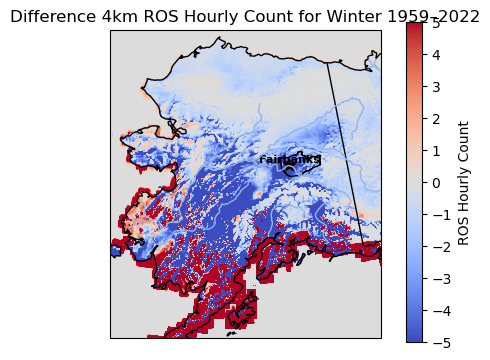

In [79]:


season_sums_31to4 = ERA5_31_to_4km['ros_tally'].sum(dim='month')
season_avg_31to4=np.mean(season_sums_31to4,axis=0)
season_sum_4=ERA5_4km['ros_tally'].sum(dim='month')
season_avg_4=np.mean(season_sum_4,axis=0)

diff=season_avg_31to4-season_avg_4

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    figsize=(10, 4))

pm = ax.pcolormesh(
    lon,
    lat,
    diff,
    cmap='coolwarm',
    vmin=-5,
    vmax=5,
    shading='auto',   # IMPORTANT
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pm, ax=ax, label='ROS Hourly Count')
cbar.set_ticks(np.arange(-5, 6,1))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=1,
    zorder=2,
    transform=ccrs.PlateCarree())

ax.scatter(
    Fairbanks_lon,
    Fairbanks_lat,
    marker='*',
    color='k',
    zorder=5,
    s=75,
    label='Fairbanks',
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.text(
    Fairbanks_lon,
    Fairbanks_lat + 0.05,
    'Fairbanks',
    transform=ccrs.PlateCarree(),
    ha='center',
    va='bottom',
    fontsize=8,
    zorder=6,
    fontweight='bold',
    color='black'
)

ax.set_title("Difference 4km ROS Hourly Count for Winter 1959–2022")
ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

NameError: name 'cmap' is not defined

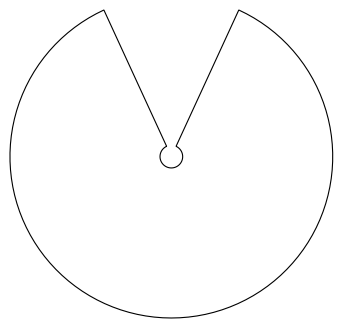

In [37]:
season_sums = ERA5_31km_regridded['ros_tally'].sum(dim='month')
seasonal_averageROS_Hrs = season_sums.mean(dim='season')

# TRANSPOSE IS CRITICAL
#seasonal_averageROS_Hrs = seasonal_averageROS_Hrs.transpose("latitude", "longitude")

lon2d, lat2d = np.meshgrid(ERA5_31km_regridded['west_east'].values, ERA5_31km_regridded['south_north'].values)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW,figsize=(10, 4))

mesh = ax.pcolormesh(
    lon2d,
    lat2d,
    seasonal_averageROS_Hrs.values,
    cmap=cmap,
    norm=norm,
    shading="auto",
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(mesh, ax=ax, label='ROS Hourly Count', extend='max')
cbar.set_ticks(np.arange(0, 13, 1))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(
    ax=ax, facecolor='none', edgecolor='black',
    linewidth=1, zorder=2, transform=ccrs.PlateCarree()
)
ax.scatter(
    Fairbanks_lon, Fairbanks_lat,
    marker='*', color='k', zorder=5, s=75,
    label='Fairbanks', transform=ccrs.PlateCarree()
)
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=8,zorder=6, fontweight='bold', color='black'
)

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title("Average ROS Hourly Count REGRIDDED\n for 1950-2022")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


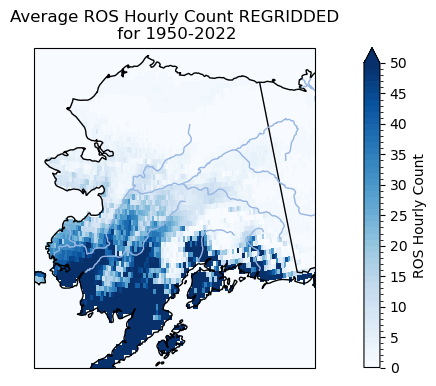

In [63]:
season_sums = ERA5_4km_regridded['ros_tally'].sum(dim='month')
seasonal_averageROS_Hrs = season_sums.mean(dim='season')

seasonal_averageROS_Hrs = seasonal_averageROS_Hrs.transpose("latitude", "longitude")

lon2d, lat2d = np.meshgrid(ERA5_4km_regridded['longitude'].values, ERA5_4km_regridded['latitude'].values)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW,figsize=(10, 4))

mesh = ax.pcolormesh(
    lon2d,
    lat2d,
    seasonal_averageROS_Hrs.values,
    cmap=cmap,
    norm=norm,
    shading="auto",
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(mesh, ax=ax, label='ROS Hourly Count', extend='max')
cbar.set_ticks(np.arange(0, 51, 1)[::5])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title("Average ROS Hourly Count REGRIDDED\n for 1950-2022")
ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()